In [5]:
import warnings
import re
from PIL import Image
# 使用pip3 install wordcloud -i http://pypi.douban.com/simple/ --trusted-host pypi.douban.com
from wordcloud import WordCloud 
import pandas as pd
import numpy as np
import umap # umap-learn==0.3.10
import matplotlib.pyplot as plt
import seaborn as sns # seaborn==0.9.0
from gensim.models.doc2vec import Doc2Vec, TaggedDocument # gensim==3.8.1
from nltk.tokenize import word_tokenize # nltk==3.4.5, 可能需要下载nltk_data
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')

# display options for pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
# pd.reset_option('display.max_colwidth')

In [6]:
# movie titles
mv_genres = pd.read_csv('C:/Users/June/Desktop/zhsj/ml-latest/ml-latest/movies.csv')
# movie tags
mv_tags = pd.read_csv('C:/Users/June/Desktop/zhsj/ml-latest/ml-latest/genome-scores.csv')
# movie tag descriptions
mv_tags_desc = pd.read_csv('C:/Users/June/Desktop/zhsj/ml-latest/ml-latest/genome-tags.csv')

In [7]:
# movies.csv文件中的原titile字段，拆分成titile和year两个字段，同时更正一些错误
def movie_title_clean(title):
  # search title for (year) pattern
  s = re.search('\(([^)]+)', title)

  # if pattern exists, remove from string
  year = 9999
  if s:
    title = title[:s.span()[0]].strip()
    year = s.group(1)
    # check if year is actual year
    if str(year).isdigit():
      year = int(year)
    else:
      year = 9999  
  
  # if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
  if title[-5:] == ', The':
    title = 'The ' + title[:-5]
  elif title[-4:] == ', An':
    title = 'An ' + title[:-4]
  elif title[-3:] == ', A':
    title = 'A ' + title[:-3]
    
  return title, year

In [8]:
# clean title and extract release year
mv_genres['title'] = mv_genres['title'].str.strip()
mv_genres['Title_Year'] = mv_genres['title'].map(movie_title_clean)
mv_genres['Title'] = mv_genres['Title_Year'].apply(lambda x: x[0])
mv_genres['Release Year'] = mv_genres['Title_Year'].apply(lambda x: x[1])

In [9]:
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995


In [10]:
# create binary indicators for each genre
# source: https://datascience.stackexchange.com/questions/14847/multiple-categorical-values-for-a-single-feature-how-to-convert-them-to-binary-u
mv_genres_stack = mv_genres[mv_genres['genres'] != '(no genres listed)'].set_index('movieId').genres.str.split('|', expand = True).stack()
mv_genres_explode = pd.get_dummies(mv_genres_stack, prefix = 'g').groupby(level = 0).sum().reset_index()
del mv_genres_stack

# genre vector (binary string)
mv_genres_explode['genre_vector'] = mv_genres_explode.iloc[:,1:].values.tolist()

# check out genre vector
mv_genres_explode.head(3)

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


# Q1: How many tags do we need or each movie?

In [11]:
# number of tags
len(np.unique(mv_tags_desc.tagId.values))

1128

In [12]:
# number of movies
len(np.unique(mv_tags.movieId.values))

13176

In [13]:
# number of movie, tag pairs
len(mv_tags)

14862528

In [14]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(mv_genres, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

In [15]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.Title == 'Forrest Gump'][['movieId','Title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(10)

,movieId,Title,tag,relevance,relevance_rank
386529,356,Forrest Gump,oscar (best music - original score),1.00000,1
386527,356,Forrest Gump,oscar (best effects - visual effects),0.99975,2
386531,356,Forrest Gump,oscar (best picture),0.99150,3
386526,356,Forrest Gump,oscar (best editing),0.98325,4
386074,356,Forrest Gump,destiny,0.97850,5
386375,356,Forrest Gump,life,0.97800,6
386311,356,Forrest Gump,imdb top 250,0.96750,7
386525,356,Forrest Gump,oscar (best directing),0.96725,8
386810,356,Forrest Gump,touching,0.96575,9
386521,356,Forrest Gump,oscar (best actor),0.95775,10


In [16]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Box Plot: Tag Relevance Score by Rank')

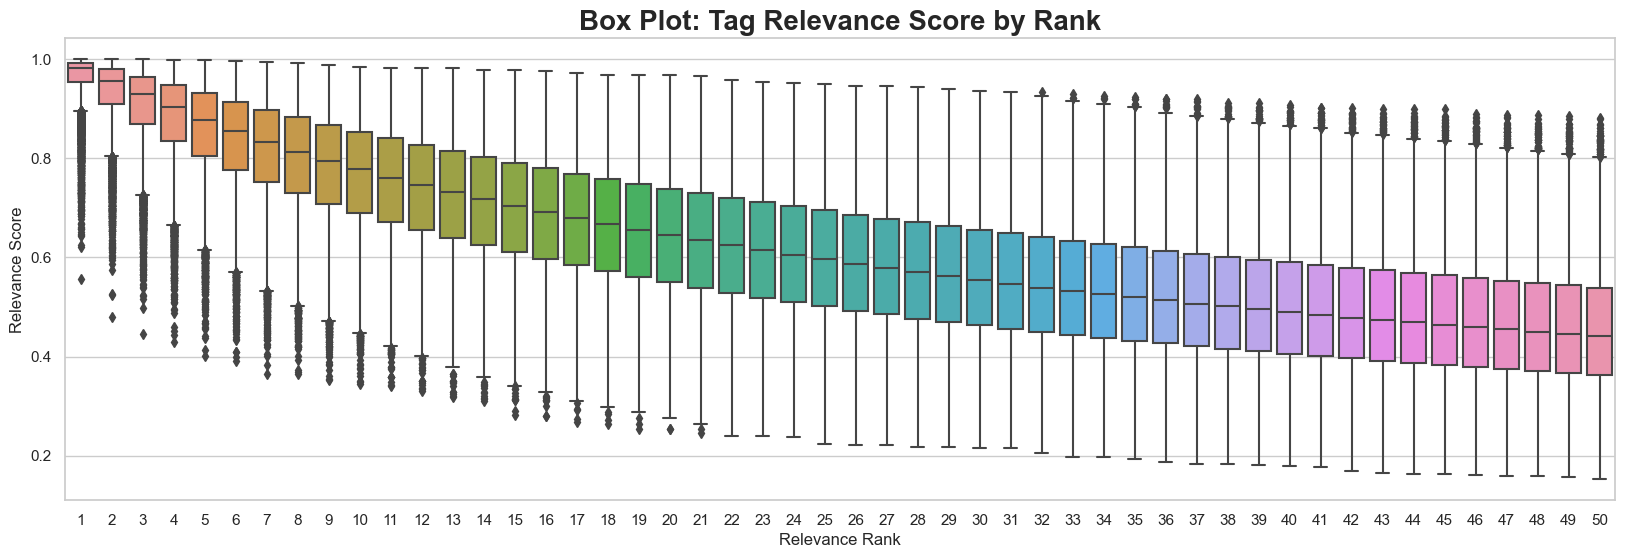

In [17]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(20, 6))

ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 50], showfliers = True)
ax.set(ylabel = "Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("Box Plot: Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

Text(0.5, 1.0, '% Change in Tag Relevance Score by Rank')

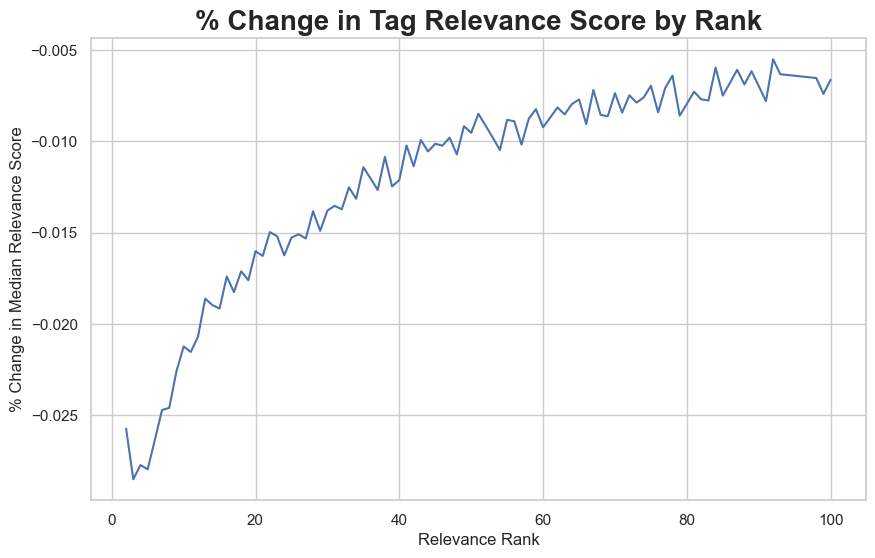

In [18]:
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = mv_tags_rank_agg)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

In [19]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','Title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [20]:
mv_tags_list.head(1)

,movieId,Title,tag,tag_list
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty","[3d, action, adventure, affectionate, animal movie, animals, animated, animation, based on book, buddy movie, cartoon, catastrophe, cgi, chase, childhood, children, classic, clever, colourful, comedy, computer animation, cool, creativity, cute, cute!, destiny, dialogue, dinosaurs, disney, disney animated feature, entertaining, excellent, excellent script, exciting, family, fantasy, fast paced, feel good movie, feel-good, friendship, fun, fun movie, funny, good, good acting, good action, good soundtrack, good versus evil, great, great ending, great movie, happy ending, heartwarming, highly quotable, humor, humorous, imagination, imdb top 250, intense, interesting, kids, kids and family, light, masterpiece, mentor, monsters, nostalgic, original, original plot, oscar, oscar (best animated feature), oscar (best directing), oscar (best effects - visual effects), oscar (best writing - screenplay written directly for the screen), oscar winner, pixar, pixar animation, quotable, realistic, redemption, runaway, secrets, simple, story, storytelling, suprisingly clever, suspense, sweet, talking animals, talky, technology, touching, toys, unlikely friendships, very funny, very good, visual, visually stunning, whimsical, witty]"


In [21]:
pd.set_option('display.max_colwidth', -1)

mv_tags_list.loc[mv_tags_list.Title == 'Parasite', ['movieId','Title','tag_list']]

,movieId,Title,tag_list
2006,2256,Parasite,"[3d, 80s, action, alien, alternate reality, android(s)/cyborg(s), bad acting, bad cgi, bad ending, bad plot, bad science, bad script, boring, boring!, brutality, california, campy, catastrophe, chase, cheesy, cinematography, clones, cult classic, cult film, cyberpunk, desert, dialogue, disaster, dystopia, effects, fantasy world, fight scenes, first contact, franchise, fun movie, future, futuristic, gangsters, graphic design, graphic novel, great ending, grindhouse, harsh, horror, idiotic, independent film, intense, kick-butt women, lame, life & death, lone hero, los angeles, low budget, mad scientist, melancholic, mentor, monster, monsters, natural disaster, not funny, notable nudity, nudity (full frontal - notable), nudity (topless - notable), nudity (topless), original, overrated, paranoia, plot holes, pointless, pornography, post apocalyptic, post-apocalyptic, predictable, runaway, sci fi, sci-fi, science fiction, scifi, sexualized violence, silly, silly fun, so bad it's funny, solitude, special effects, spiders, splatter, story, storytelling, stylized, suspense, technology, transformation, unusual plot structure, vampire human love, vengeance, violence, violent, visual, visually appealing, weapons]"


# Q2: How do we use tags to measure the similarity between movies?

In [22]:
# compute Jaccard Index to get most similar movies to target movie

pd.reset_option('display.max_colwidth')

target_movie = 'The Matrix'

target_tag_list = mv_tags_list[mv_tags_list.Title == target_movie].tag_list.values[0]
mv_tags_list_sim = mv_tags_list[['movieId','Title','tag_list','tag']]
mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to 《{target_movie}》 based on tags:')
text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)

Movies most similar to 《The Matrix》 based on tags:


,movieId,Title,tag_list,tag,jaccard_sim
2304,2571,The Matrix,"[action, action packed, allegory, alternate re...","action,action packed,allegory,alternate realit...",1.000000
5601,6365,The Matrix Reloaded,"[action, action packed, alternate reality, alt...","action,action packed,alternate reality,alterna...",0.503759
5246,5903,Equilibrium,"[action, action packed, allegory, alternate re...","action,action packed,allegory,alternate realit...",0.459854
10258,79132,Inception,"[action, action packed, alternate reality, ama...","action,action packed,alternate reality,amazing...",0.449275
4884,5445,Minority Report,"[action, action packed, adapted from:book, alt...","action,action packed,adapted from:book,alterna...",0.418440
6029,6934,The Matrix Revolutions,"[action, action packed, adventure, alone in th...","action,action packed,adventure,alone in the wo...",0.418440
11703,109487,Interstellar,"[70mm, adventure, amazing photography, astrona...","70mm,adventure,amazing photography,astronauts,...",0.388889
11800,111759,Edge of Tomorrow,"[action, action packed, adapted from:comic, al...","action,action packed,adapted from:comic,alien,...",0.388889
11114,96610,Looper,"[action, action packed, alternate reality, alt...","action,action packed,alternate reality,alterna...",0.379310
1117,1240,The Terminator,"[80s, action, action packed, adventure, afi 10...","80s,action,action packed,adventure,afi 100 (mo...",0.379310


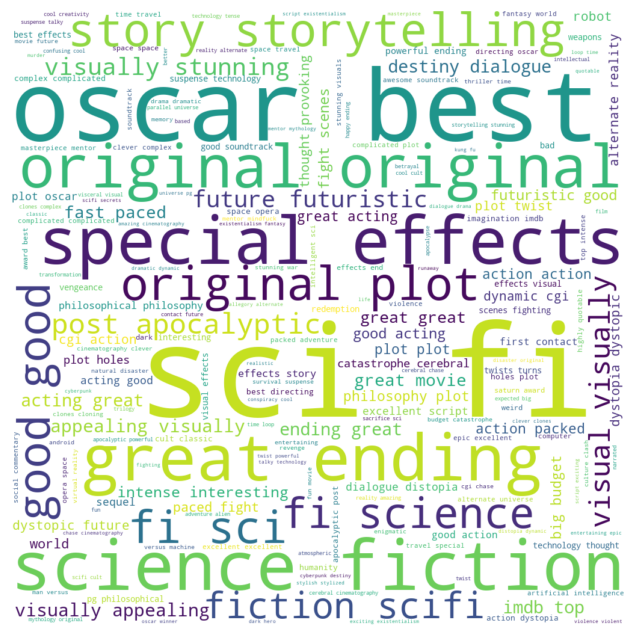

In [23]:
plt.rcParams["figure.figsize"] = (15,10)

# Generate a word cloud image
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# corpus of movie tags
mv_tags_corpus = mv_tags_list.tag.values
print(mv_tags_corpus)

['3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,s

In [25]:
# 第一次运行，使用stopwords前先运行下面两句
# import nltk
# nltk.download('stopwords')

stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
  tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
  tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
  return tokens

In [26]:
# preprocess corpus of movie tags before feeding it into Doc2Vec model
mv_tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(mv_tags_corpus)]

In [27]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)
  
model.build_vocab(mv_tags_doc)

In [28]:
# train Doc2Vec model
# stochastic (random initialization), so each run will be different unless you specify seed

print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(mv_tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [29]:
# listing space embeddings
mv_tags_vectors = model.docvecs.vectors_docs

In [30]:
mv_tags_vectors.shape

(13176, 20)

In [31]:
# top similar movies based on cosine similarity

mv = 'Good Will Hunting'

mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]

print(mv_tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
  print(mv_tags_list.loc[int(i), "movieId"].strip())

[-1.3008357  -0.05328732 -0.8098972  -1.3969246  -0.59571177  0.64971465
 -0.84054834 -0.4021823   0.27608132  0.24354999  1.1903775  -0.8051427
 -0.43196943  0.86921906 -1.1757383  -0.6417338  -0.8885676  -0.01469036
  0.8902242  -0.5214043 ]
Dead Poets Society
The Big Chill
Almost Famous
Children of a Lesser God
Steve Jobs
Walk the Line
The Theory of Everything
The Truman Show
Starting Out in the Evening
Up in the Air
Educating Rita
Rain Man
Finding Forrester
Genius
St. Vincent
Mr. Holland's Opus
Pay It Forward
Little Man Tate
Stand and Deliver
The Perks of Being a Wallflower
Broadcast News
Being Julia
The Paper Chase
Sideways
The Edge of Seventeen
On Golden Pond
Another Woman
Charly
A Beautiful Mind
The Social Network


# Q3: How do we use tags to generate movie recommendations for a user?

In [33]:
# history of movies the user watched and liked
user_movies = ['Interstellar','Good Will Hunting','Gattaca',
               'Almost Famous','The Shawshank Redemption','Edge of Tomorrow',
               'Jerry Maguire','Forrest Gump','Back to the Future']

# compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape = mv_tags_vectors.shape[1])
for mv in user_movies:
  mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
  user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)  

# print(user_movie_vector)
  
#  find movies similar to user vector to generate movie recommendations

print('Movie Recommendations:')

sims = model.docvecs.most_similar(positive = [user_movie_vector], topn = 30)

for i, j in sims:
  movie_sim = mv_tags_list.loc[int(i), "Title"].strip()
  if movie_sim not in user_movies:
    print(movie_sim)

Movie Recommendations:
Dead Poets Society
Amadeus
A Beautiful Mind
The Truman Show
The Theory of Everything
Taps
It's a Wonderful Life
Children of a Lesser God
Star Trek: First Contact
E.T. the Extra-Terrestrial
Star Wars: Episode V - The Empire Strikes Back
Cast Away
La La Land
Star Wars: Episode IV - A New Hope
Peaceful Warrior
Steve Jobs: The Lost Interview
Without Limits
Transcendent Man
Star Trek II: The Wrath of Khan
The Aviator
Star Wars: The Last Jedi
The Curious Case of Benjamin Button
Rush
Citizen Kane
The Glenn Miller Story
Mr. Holland's Opus


持久化保存电影推荐模型、处理过的数据

In [34]:
model.save('TagRec.model')

In [49]:
print(type(mv_tags_list))
mv_tags_list

<class 'pandas.core.frame.DataFrame'>


,movieId,Title,tag,tag_list
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...","[3d, action, adventure, affectionate, animal m..."
1,2,Jumanji,"action,action packed,adaptation,adapted from:b...","[action, action packed, adaptation, adapted fr..."
2,3,Grumpier Old Men,"adaptation,adventure,bad plot,beautiful scener...","[adaptation, adventure, bad plot, beautiful sc..."
3,4,Waiting to Exhale,"adaptation,adapted from:book,adultery,bad acti...","[adaptation, adapted from:book, adultery, bad ..."
4,5,Father of the Bride Part II,"adaptation,bad plot,bad sequel,betrayal,better...","[adaptation, bad plot, bad sequel, betrayal, b..."
...,...,...,...,...
13171,185435,"Game Over, Man!","1970s,80s,absurd,action,adaptation,alter ego,a...","[1970s, 80s, absurd, action, adaptation, alter..."
13172,185585,Pacific Rim: Uprising,"action,adaptation,adventure,allegory,bad actin...","[action, adaptation, adventure, allegory, bad ..."
13173,186587,Rampage,"action,adapted from:comic,aliens,allegory,anim...","[action, adapted from:comic, aliens, allegory,..."
13174,187593,Deadpool 2,"absurd,action,adaptation,anti-hero,betrayal,be...","[absurd, action, adaptation, anti-hero, betray..."


In [52]:
df_save = mv_tags_list[["movieId", "Title"]]
df_save.to_csv('df_save.csv')

加载模型，推荐电影

In [53]:
from gensim.models import word2vec,Word2Vec
TagRec_model = Word2Vec.load('TagRec.model')
mv_tags_vectors = TagRec_model.docvecs.vectors_docs

# history of movies the user watched and liked
user_id = 1
# 这里在实际应用中要从`ratings.csv`中获得用户标记过的movieid
user_movies_index = [11703, 1523, 1475, 3492, 305, 11800, 1261, 342, 1147, 100] 

# compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape = mv_tags_vectors.shape[1])
for mv_index in user_movies_index:
  # mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0] 
  # print(mv_index)
  user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies_index)  
  
#  find movies similar to user vector to generate movie recommendations

print('Movie Recommendations:')

sims = model.docvecs.most_similar(positive = [user_movie_vector], topn = 30)

for i, j in sims:
  movie_sim = mv_tags_list.loc[int(i), "movieId"]
  if movie_sim not in user_movies_index:
    print(movie_sim)

Movie Recommendations:
1704
356
4995
109487
1246
318
117176
1356
1682
1225
953
84154
4022
179819
5237
164909
1196
1653
1097
104913
64957
2312
30812
45503
134130
97779
1374
1375
4370
923
